In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import argparse
import pandas as pd
import os 
from functools import partial
from pathos.multiprocessing import ProcessingPool as Pool
import gzip
import snappy
import time

%matplotlib inline

In [8]:
def create_data_sets(df, train_percent=0.1):
    # shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    # split the data
    train_size = int(len(df) * 1.0)
    df = df[:train_size]
    train_size = int(len(df) * train_percent)
    train_df = df[:train_size]
    test_df = df[train_size:]
    return train_df, test_df

# function to calculate distance between two entries in train and test
# returns the distance between the two entries
def distance_calc(compression, test, train, i, j):
    # get the ith row from test and jth row from train
    # calculate the distance between the two rows using cosine similarity
    # return the distance

    test_string = test.iloc[i]['sequence']
    train_string = train.iloc[j]['sequence']

    encoding = 'utf-8'
    # set the compression algorithm
    # calculate the distance between the two strings
    # print progress percentage to stdout with 2 decimal places
    # Access the compression module from the global scope
    compressor = globals().get(compression)
    if compressor is None:
        raise ValueError(f"Compression method '{compression}' is not available.")

    Cx1 = len(compressor.compress(test_string.encode(encoding)))
    Cx2 = len(compressor.compress(train_string.encode(encoding)))
    Cx1x2 = len(compressor.compress((" ".join([test_string, train_string])).encode(encoding)))

    distance = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return [i, j, distance]

# create distance matrix
# returns a distance matrix
def create_distance_matrix(train, test, pool, compression='gzip'):
    # create an empty matrix of size len(test) x len(train)
    # iterate over each row in train and test and calculate distance using pool
    # return the distance matrix
    distance_matrix = np.zeros((len(test), len(train)))
    # pool calculation with two ranges
    
    for i in range(len(test)):
        result = pool.map(partial(distance_calc, compression, test, train, i), range(len(train)))
        for j in result:
            distance_matrix[j[0]][j[1]] = j[2]
        print('Progress: {:.2f}%'.format((i) / (len(test)) * 100), end='\r')    
    return distance_matrix

In [9]:
human_dna = pd.read_table('human.txt')
human_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [10]:
human_dna.shape

(4380, 2)

In [11]:
train_df, test_df = create_data_sets(human_dna, train_percent=0.8)
print(len(train_df))
print(len(test_df))

3504
876


In [12]:
pool = Pool(8)
distance_matrix = create_distance_matrix(train_df, test_df, pool, compression='snappy')

In [13]:
# size of distance matrix
print(distance_matrix.shape)

# return the index of the minimum value in the rows of distance matrix
predictions = []
for i in range(distance_matrix.shape[0]):
    # return the indices of the first 5 minimum values in the row
    indices = np.argmin(distance_matrix[i, :])
    labels = train_df['class'][indices]
    # get the common label
    predictions.append(labels)

# get the actual labels
labels = test_df['class'].values
# print the predictions
print(predictions)
# print the actual labels
print(labels)

# calculate accuracy
accuracy = np.sum(predictions == labels) / len(labels)

# print the accuracy
print(accuracy)



(876, 3504)
[6, 0, 4, 0, 2, 6, 5, 6, 6, 5, 1, 6, 4, 1, 6, 0, 4, 4, 6, 6, 6, 3, 2, 4, 6, 5, 1, 3, 3, 6, 4, 3, 6, 4, 6, 2, 2, 2, 2, 6, 0, 3, 0, 3, 4, 0, 0, 6, 2, 6, 1, 6, 5, 6, 0, 6, 6, 3, 6, 4, 6, 4, 6, 6, 6, 3, 6, 6, 1, 4, 3, 1, 0, 6, 6, 3, 4, 6, 6, 6, 1, 6, 4, 6, 4, 1, 6, 6, 1, 1, 6, 2, 0, 6, 5, 4, 4, 4, 3, 6, 2, 6, 5, 1, 6, 0, 1, 3, 0, 3, 6, 4, 1, 2, 4, 6, 5, 6, 1, 6, 5, 0, 3, 6, 6, 1, 0, 1, 2, 1, 3, 2, 4, 5, 2, 2, 1, 3, 6, 2, 6, 5, 2, 4, 1, 0, 4, 6, 6, 1, 4, 4, 4, 2, 3, 6, 6, 6, 1, 4, 3, 3, 3, 3, 3, 3, 6, 3, 4, 6, 3, 0, 4, 2, 6, 4, 6, 3, 4, 2, 5, 1, 2, 3, 0, 4, 5, 3, 6, 0, 0, 1, 5, 0, 1, 1, 6, 2, 6, 6, 1, 4, 2, 1, 4, 4, 2, 0, 5, 6, 4, 2, 0, 4, 3, 0, 3, 3, 6, 6, 0, 1, 6, 1, 0, 1, 6, 4, 5, 6, 0, 6, 6, 3, 2, 6, 2, 6, 1, 3, 2, 5, 5, 6, 5, 6, 3, 0, 1, 3, 4, 6, 3, 6, 6, 1, 4, 1, 0, 1, 3, 6, 0, 5, 5, 6, 1, 3, 3, 6, 6, 1, 3, 2, 1, 4, 1, 6, 2, 4, 5, 5, 5, 3, 4, 6, 0, 2, 6, 2, 2, 6, 6, 3, 3, 6, 3, 0, 3, 4, 0, 3, 4, 4, 3, 0, 6, 4, 1, 3, 6, 1, 6, 2, 6, 6, 3, 1, 6, 3, 6, 6, 0, 5, 4, 1, 3, 1, 3, 

In [16]:
# create confusion matrix
def create_confusion_matrix(predictions, labels):
    # create an empty confusion matrix of size 4x4
    # iterate over each prediction and label and update the confusion matrix
    # return the confusion matrix
    confusion_matrix = np.zeros((7, 7))
    for i in range(len(predictions)):
        confusion_matrix[predictions[i]][labels[i]] += 1
    return confusion_matrix

# print the confusion matrix
print(create_confusion_matrix(predictions, labels))

[[ 84.   1.   0.   1.   2.   0.   1.]
 [  0. 103.   0.   1.   0.   1.   4.]
 [  1.   0.  80.   0.   0.   0.   0.]
 [  1.   2.   2. 114.   0.   1.   4.]
 [  2.   0.   1.   3. 135.   1.   6.]
 [  6.   0.   0.   2.   2.  44.   6.]
 [  9.   6.   0.   5.   4.   0. 241.]]


Text(0.5, 1.0, 'Class distribution of Human DNA')

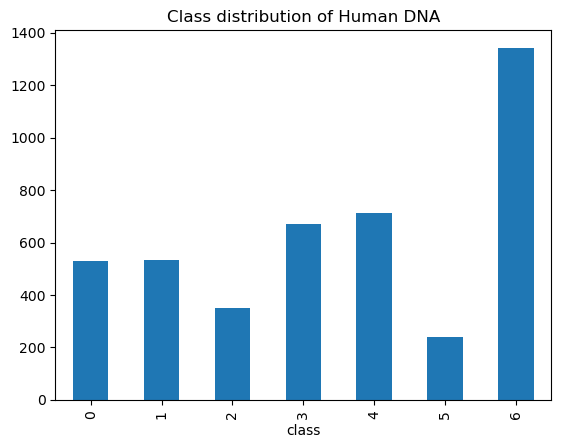

In [4]:
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

In [6]:
chimp_dna = pd.read_table('chimpanzee.txt')
chimp_dna.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

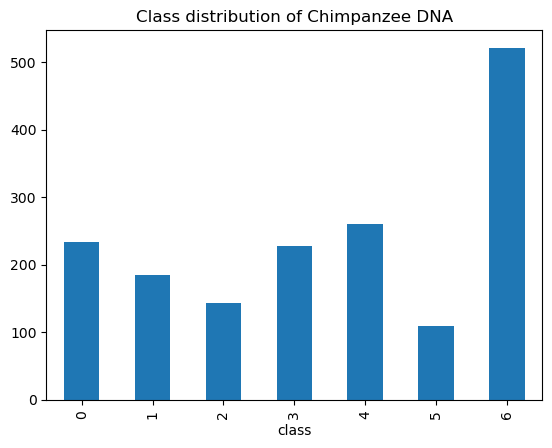

In [7]:
chimp_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

In [8]:
dog_dna = pd.read_table('dog.txt')
dog_dna.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


Text(0.5, 1.0, 'Class distribution of Dog DNA')

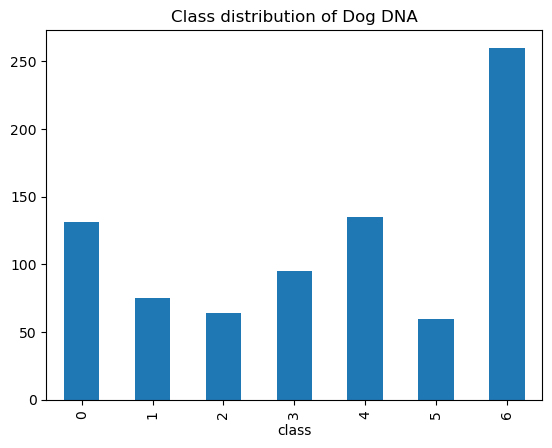

In [9]:
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

In [10]:
print("Human DNA shape: ", human_dna.shape)
print("Chimpanzee DNA shape: ", chimp_dna.shape)
print("Dog DNA shape: ", dog_dna.shape)

Human DNA shape:  (4380, 2)
Chimpanzee DNA shape:  (1682, 2)
Dog DNA shape:  (820, 2)


In [ ]:


# function to calculate accuracy of the model
# returns the accuracy of the model
def calculate_accuracy(distance_matrix, data):
    data[args.df_predicted_label_field_name] = ''
    for i in range(len(distance_matrix)):
        # return the indices of maximum K values in the distance matrix
        #indices = np.argpartition(distance_matrix[i], -args.k)[-args.k:]

        indices = np.argpartition(distance_matrix[i], args.k)[:args.k]
        
        # get the labels of the indices
        labels = data.iloc[indices, data.columns.get_loc(args.df_label_field_name)].values.tolist()
        # get the unique labels and their counts
        unique_labels, counts = np.unique(labels, return_counts=True)
        # get the label with the maximum count
        label = unique_labels[np.argmax(counts)]
        # set the label of the test entry to the predicted label field
        

        sorted_idx = np.argsort(np.array(distance_matrix[i]))
        top_k_class = list(data.iloc[sorted_idx[:args.k], data.columns.get_loc(args.df_label_field_name)])
        
        print(label, top_k_class)
        label = max(set(top_k_class), key = top_k_class.count)
        
        data.iloc[i, data.columns.get_loc(args.df_predicted_label_field_name)] = label
 

    accuracy = len(data[data[args.df_label_field_name] == data[args.df_predicted_label_field_name]])/len(data)
    # return the accuracy at call level
    # get unique values of call_record_id
    unique_call_record_ids = data['call_record_id'].unique()
    # iterate over each call_record_id and calculate accuracy
    accuracy2 = 0
    for call_record_id in unique_call_record_ids:
        if len(data[(data['call_record_id'] == call_record_id) & (data[args.df_label_field_name] == data[args.df_predicted_label_field_name])]) == 2:
            accuracy2 += 1

    print(accuracy, accuracy2/len(unique_call_record_ids),len(data))

    # create a new dataframe
    new_data = pd.DataFrame(columns=data.columns)

    subcount = 0
    # iterate over each call_record_id
    for call_record_id in unique_call_record_ids:
        # get the rows with the current call_record_id
        rows = data[data['call_record_id'] == call_record_id]

        if len(rows[rows[args.df_label_field_name] == rows[args.df_predicted_label_field_name]]) == 2:
            new_data = new_data.append(rows.iloc[0])
            new_data = new_data.append(rows.iloc[1])
            subcount += 1

    # subsubcount = 0
    # for call_record_id in unique_call_record_ids:
    #     # get the rows with the current call_record_id
    #     rows = data[data['call_record_id'] == call_record_id]

    #     if len(rows[rows[args.df_label_field_name] == rows[args.df_predicted_label_field_name]]) == 1 and subsubcount <= 0.1*subcount:
    #         new_data = new_data.append(rows.iloc[0])
    #         new_data = new_data.append(rows.iloc[1])
    #         subsubcount += 1

    data = new_data

    unique_call_record_ids = data['call_record_id'].unique()


    accuracy = len(data[data[args.df_label_field_name] == data[args.df_predicted_label_field_name]])/len(data)
    
    # iterate over each call_record_id and calculate accuracy
    accuracy2 = 0
    for call_record_id in unique_call_record_ids:
        if len(data[(data['call_record_id'] == call_record_id) & (data[args.df_label_field_name] == data[args.df_predicted_label_field_name])]) == 2:
            accuracy2 += 1

    print(accuracy, accuracy2/len(unique_call_record_ids),len(data))

    return  data

def main():
    # create a pool of processes
    pool = Pool(args.num_processors)
    train, test, all_data = read_data(args.data_folder)
    print(train.head())
    print(test.head())


    print(train.head())
    print(test.head())
    print(all_data.head())
    print(train.shape)
    print(test.shape)
    print(all_data.shape)

    
    # create distance matrix, if distance matrix is not manually given
    if args.distance_matrix_file is None:
        distance_matrix = create_distance_matrix(all_data, all_data, pool)
        # save distance matrix to file. The file name should be in the format distance_matrix_<unixtime>.npy
        np.save(os.path.join(args.output_folder, 'distance_matrix_{}.npy'.format(int(time.time()))), distance_matrix)

    else:
        # load distance matrix from file
        distance_matrix = np.load(args.distance_matrix_file)
    
    print(distance_matrix)
    print(distance_matrix.shape)

    new_data  = calculate_accuracy(distance_matrix, all_data)

    print(new_data.head())
    print(new_data.shape)
    new_data.to_csv(os.path.join(args.output_folder, 'new_data_{}.csv'.format(int(time.time()))), index=False)

    # create a new dataset
    #new_data = create_new_dataset(new_data)
    

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Run a multi-process experiment.')
    parser.add_argument('--num_processors', type=int, help='number of processors to run', default=1)
    parser.add_argument('--data_folder', type=str, help='folder containing data', default='step4')
    parser.add_argument('--output_folder', type=str, help='folder to output results', default='output')
    parser.add_argument('--num_words', type=int, help='number of words in each chunk', default=0)
    parser.add_argument('--df_text_field_name', type=str, help='name of field in dataframe to chunk', default='text')
    parser.add_argument('--df_label_field_name', type=str, help='name of field in dataframe to use as index', default='speaker')
    parser.add_argument('--df_predicted_label_field_name', type=str, help='name of field in dataframe to use as index', default='predicted_speaker')
    parser.add_argument('--distance_matrix_file', type=str, help='file containing distance matrix', default=None)
    
    parser.add_argument('--k', type=int, help='number of nearest neighbors to use', default=5)

    args = parser.parse_args()

    print(args.num_processors)
    print(args.data_folder)
    main()